# PREPARE DATA

In [181]:
# Import libraries
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


def is_time_between(start_hour, end_hour, check_hour):
    if start_hour < end_hour:
        return start_hour <= check_hour <= end_hour
    else:  # crosses midnight
        return check_hour >= start_hour or check_hour <= end_hour
    
def is_time_between_exc(start_hour, end_hour, check_hour):
    if start_hour < end_hour:
        return start_hour >= check_hour < end_hour
    else:  # crosses midnight
        return check_hour >= start_hour or check_hour < end_hour

dataset_name = "GBP_CHF_H1"
# Read the ohlcv data
# oanda_path = "/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data"
oanda_path = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"
df = pd.read_csv(f'{oanda_path}/{dataset_name}_processed_data.csv')
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
# drop na values
df = df.dropna()
# filter when time is only in 2016
df = df[df["Time"] >= "2020-01-01 00:00:00"]
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index,EMA_100
96406,2020-01-01 22:00:00+00:00,1.28359,1.28399,1.28016,1.28250,288,1.276865,1.274779,1.274847,1.274648,...,-21.995630,1.283815,1.282132,1.280449,2.770750e+06,2996.385016,39.345057,69.268434,96406,1.275501
96407,2020-01-01 23:00:00+00:00,1.28262,1.28294,1.28126,1.28234,2539,1.277453,1.275189,1.274985,1.274769,...,-24.863174,1.283893,1.282240,1.280587,2.771476e+06,2825.870311,44.959336,65.072056,96407,1.275636
96408,2020-01-02 00:00:00+00:00,1.28234,1.28432,1.28220,1.28368,3282,1.278128,1.275609,1.275165,1.274927,...,-15.257048,1.284194,1.282776,1.281358,2.772776e+06,2912.985433,46.712611,62.799266,96408,1.275796
96409,2020-01-02 01:00:00+00:00,1.28368,1.28415,1.28298,1.28316,3578,1.278810,1.276038,1.275330,1.275072,...,-20.274914,1.284112,1.283040,1.281968,2.770299e+06,1895.645741,47.431040,58.876001,96409,1.275941
96410,2020-01-02 02:00:00+00:00,1.28318,1.28354,1.28216,1.28247,2309,1.279467,1.276450,1.275467,1.275183,...,-26.202749,1.283854,1.282830,1.281806,2.769027e+06,902.522512,44.651640,63.397342,96410,1.276071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121208,2023-12-22 17:00:00+00:00,1.08930,1.08961,1.08715,1.08785,5379,1.086893,1.086822,1.088077,1.092102,...,-34.851485,1.089995,1.087424,1.084853,3.782916e+06,1158.874604,48.773249,58.804153,121208,1.091541
121209,2023-12-22 18:00:00+00:00,1.08784,1.08786,1.08727,1.08744,4183,1.086970,1.086839,1.088015,1.091977,...,-42.970297,1.090003,1.087628,1.085253,3.781143e+06,653.492409,45.200056,54.536136,121209,1.091460
121210,2023-12-22 19:00:00+00:00,1.08744,1.08807,1.08704,1.08728,5404,1.087028,1.086814,1.087925,1.091874,...,-46.138614,1.089388,1.087962,1.086536,3.778258e+06,-530.818593,49.284951,48.776857,121210,1.091377
121211,2023-12-22 20:00:00+00:00,1.08726,1.08734,1.08642,1.08678,3602,1.087033,1.086835,1.087841,1.091775,...,-56.039604,1.089443,1.087730,1.086017,3.777475e+06,-1216.203419,44.064442,48.959986,121211,1.091286


## STRATEGY ADAPTIVE PROFIT

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_one = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    condition_two = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    if position == 0:
        if condition_one:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_two:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        else:
            stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# EUR_USD_H1 : off-years = 2014, 2016, 2021
# EUR_JPY_H1 : off-years = 2016
# GBP_JPY_H1 : off-years = 2023
# USD_MXN_H1 : off-years = 2018, 2019, 2022
# NZD_JPY_H1 : off-years = 2014, 2015, 2019

# AUD_HKD_H1 : off-years = 2015, 2018, 2019, 2021
# EUR_GBP_H1 : off-years = 2018, 2021, 2022, 2023

# ZAR_JPY_H1 : off-years = 2014, 2015, 2017, 2019
# USD_NOK_H1 : off-years = 2014, 2015
# USD_CHF_H1 : off-years = 2014
# TRY_JPY_H1 : off-years = 2014, 2019, 2021, 2022, 2023
# AUD_USD_H1 : off-years = 2015,2016,2018, 2019, 2022

In [ ]:
trades_df["PnL_label"].mean()

## STRATEGY FIXED PROFIT AND LOSS

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 1.5
start_hour = 13
end_hour = 17

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# AUD_HKD_H1 : off-years = 2015, 2018
# EUR_GBP_H1: 2018, 2019, 2021


## STRATEGY FIXED PROFIT AND ADAPTIVE LOSS

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward, take_profit, stop_loss]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward, take_profit, stop_loss]
        else:
            # stop loss must not be greater than the take profit
            # pass
            next_stop_loss = row['Close'] - atr_delta*row['ATR']
            if next_stop_loss < take_profit:
                stop_loss = max(stop_loss, next_stop_loss)
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward, take_profit, stop_loss]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward, take_profit, stop_loss] 
        else:
            # pass
            next_stop_loss = row['Close'] + atr_delta*row['ATR']
            if next_stop_loss > take_profit:
                stop_loss = min(stop_loss, next_stop_loss)

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL', 'Take_Profit', 'Stop_Loss'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
trades_df["cumulative_sum"].plot()

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2014].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
sub_trades_df["cumulative_sum"].plot()

In [ ]:
x = 642
y = 599

p = (x) / (x+y)
p * 100

In [ ]:
df

## OPENING RANGE BREAK-IN STRATEGY

In [185]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

atr_delta = 1.5
start_hour = 8
end_hour = 17
range_start_hour = 5

for i, row in df.iterrows():
    current_time = row["Time"]
    latest_trade_date = trades[-1][1].date() if trades else None
    current_date = current_time.date()

    if (
        position == 0
        and is_time_between_exc(start_hour, end_hour, current_time.hour)
        and current_date != latest_trade_date
    ):
        # range_df should be from range_start_hour to range_end_hour
        range_df = df[
            (df["Time"].dt.hour >= range_start_hour)
            & (df["Time"].dt.hour < start_hour)
            & (df["Time"].dt.date == current_date)
        ]
        

        if range_df.empty:
            continue
        
        opening_high = range_df["High"].max()
        opening_low = range_df["Low"].min()
        opening_range = opening_high - opening_low
        
        # print(range_df)
        # print(opening_high, opening_low, opening_range)
        
        # break
        if opening_range < row["ATR"]:
            continue

        condition_buy = (row["Close"] < opening_low)
        condition_sell = (row["Close"] > opening_high)

        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']

            # take_profit = entry_price + opening_range
            # stop_loss = entry_price - opening_range
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            
            # take_profit = entry_price - opening_range
            # stop_loss = entry_price + opening_range
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass

In [186]:
# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df["PnL_label"].mean() 

0.7804878048780488

In [187]:
trades_df

,Action,Time,Price,PnL,PnL_label
0,Buy,2020-01-02 07:00:00+00:00,1.283343,1.0,1
1,Sell,2020-01-03 01:00:00+00:00,1.274584,1.0,1
2,Sell,2020-01-07 12:00:00+00:00,1.275211,1.0,1
3,Buy,2020-01-08 02:00:00+00:00,1.271473,1.0,1
4,Buy,2020-01-09 09:00:00+00:00,1.272011,-1.0,0
...,...,...,...,...,...
651,Buy,2023-12-08 10:00:00+00:00,1.100591,1.0,1
652,Buy,2023-12-15 10:00:00+00:00,1.108198,1.0,1
653,Sell,2023-12-18 09:00:00+00:00,1.101539,1.0,1
654,Sell,2023-12-19 12:00:00+00:00,1.101111,-1.0,0


<Axes: >

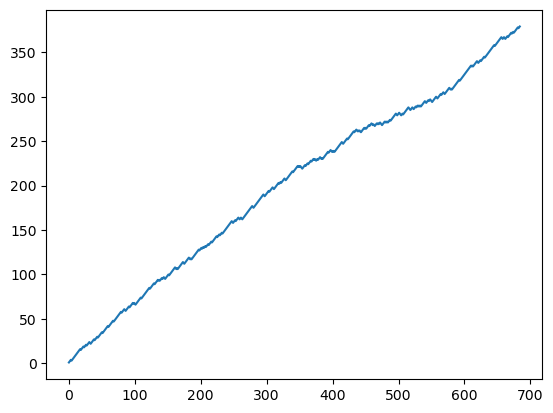

In [184]:
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
trades_df["cumulative_sum"].plot()

In [ ]:
trades_df